# PDEFIND Feature Overview

This notebook provides a simple overview of the PDE functionality of PySINDy.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

# Test PDE functionality on the 1D kdV equation
The kdV equation is
$u_t = -6uu_x - u_{xxx}$,
and the data we will be investigating is a two-soliton solution.

(512, 201) (201,) (512,)


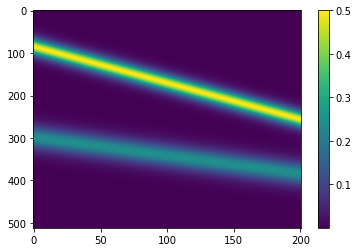

In [2]:
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.abs(kdV['usol'])   #+ np.random.randn(len(x), len(t)) / 20
dt = t[1] - t[0]
dx = x[1] - x[0]
print(np.shape(u), np.shape(t), np.shape(x))
plt.imshow(u, aspect='auto')
plt.colorbar()

# Test spatial derivative computations

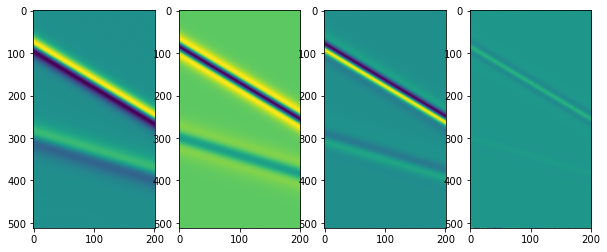

In [3]:
ux = np.zeros((len(x), len(t), 1))
uxx = np.zeros((len(x), len(t), 1))
uxxx = np.zeros((len(x), len(t), 1))
uxxxx = np.zeros((len(x), len(t), 1))
dx = x[1] - x[0]
for i in range(len(t)):
    u_temp = np.reshape(u[:, i], (len(u[:, i]), 1))
    ux[:, i] = ps.FiniteDifference(d=1)._differentiate(u_temp, dx)
    uxx[:, i] = ps.FiniteDifference(d=2)._differentiate(u_temp, dx)
    uxxx[:, i] = ps.FiniteDifference(d=3)._differentiate(u_temp, dx)
    uxxxx[:, i] = ps.FiniteDifference(d=4)._differentiate(u_temp, dx)
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(ux, aspect='auto')
plt.subplot(1, 4, 2)
plt.imshow(uxx, aspect='auto')
plt.subplot(1, 4, 3)
plt.imshow(uxxx, aspect='auto')
plt.subplot(1, 4, 4)
plt.imshow(uxxxx, aspect='auto')

In [4]:
# Need to compute u_t separately, and input into model.fit
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_temp = np.reshape(u[i, :], (len(u[i, :]), 1))
    ut[i, :] = ps.FiniteDifference()._differentiate(u_temp, t)
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]

u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1))
library_functions = [lambda x: x] #, lambda x: x * x]
library_function_names = [lambda x: x] #, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, derivative_order=3, spatial_grid=x)
#optimizer = ps.STLSQ(threshold=0.5, alpha=1e-5)
#optimizer = ps.SR3(threshold=0.1, max_iter=10000, tol=1e-10, thresholder='l1')
#optimizer = ps.SR3(threshold=0.01, max_iter=10000, thresholder='l1')
optimizer = ps.SSR(criteria='model_residual')
#optimizer = ps.SSR()


model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
print(pde_lib.get_feature_names())
model.print()
print(optimizer.history_)

['x0', 'x0_1', 'x0_11', 'x0_111', 'x0x0_1', 'x0x0_11', 'x0x0_111']
x0' = -3.004 x0x0_1
[array([[ 1.29162725e-07, -6.04373502e-02,  2.13438406e-05,
        -7.14767347e+00, -5.59550118e+00, -4.24300175e-05,
        -7.71973110e-01]]), array([[ 2.22308074e-06,  0.00000000e+00,  5.15819347e-06,
        -6.30361516e+00, -5.59913824e+00,  7.51163691e-06,
        -1.78199049e+00]]), array([[ 0.00000000e+00,  0.00000000e+00,  9.62214136e-06,
        -6.30361517e+00, -5.59913824e+00, -1.29237640e-05,
        -1.78199048e+00]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.30361517e+00, -5.59913824e+00,  8.66188511e-06,
        -1.78199048e+00]]), array([[ 0.        ,  0.        ,  0.        , -6.30361518, -5.59913825,
         0.        , -1.78199049]]), array([[ 0.        ,  0.        ,  0.        , -6.85838224, -5.55021823,
         0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -2.99613231,
         0.        ,  0.        ]])

Model 0, MSE: 0.081845
Model 1, MSE: 0.082298
Model 2, MSE: 0.082298
Model 3, MSE: 0.082298
Model 4, MSE: 0.082298
Model 5, MSE: 0.082321
Model 6, MSE: 0.085168


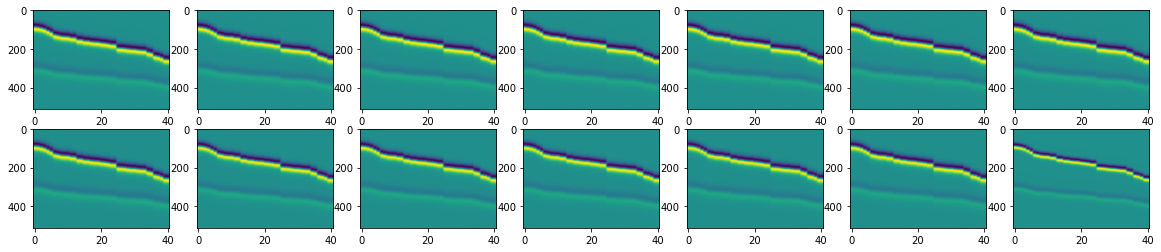

In [5]:
plt.figure(figsize=(20, 4))
for j in range(np.shape(optimizer.history_)[0]):
    optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(u_test_flattened)  
    x_dot_test_predicted = np.reshape(x_dot_test_predicted, (len(x), len(t_test), 1))

    plt.subplot(2, np.shape(optimizer.history_)[0], j + 1)
    plt.imshow(ut_test[:, :, 0], aspect='auto')
    plt.subplot(2, np.shape(optimizer.history_)[0], 
                   1 * np.shape(optimizer.history_)[0] + j + 1)
    plt.imshow(x_dot_test_predicted[:, :, 0], aspect='auto')
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(u_test_flattened, t=dt, metric=mean_squared_error))

# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

(1024, 251) (251,) (1024,)


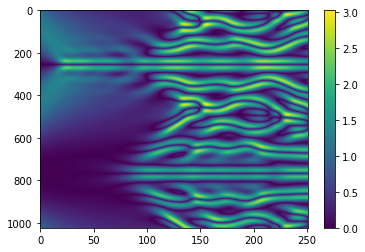

In [6]:
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = np.abs(data['uu'])   #+ np.random.randn(len(x), len(t)) / 20
print(np.shape(u), np.shape(t), np.shape(x))
plt.imshow(u, aspect='auto')
plt.colorbar()

ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_temp = np.reshape(u[i, :], (len(u[i, :]), 1))
    ut[i, :] = ps.FiniteDifference()._differentiate(u_temp, t)

In [7]:
u_flattened = np.reshape(u, (len(x) * len(t), 1))
ut_flattened = np.reshape(ut, (len(x) * len(t), 1))
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, derivative_order=4, spatial_grid=x)
#optimizer = ps.STLSQ(threshold=0.001, alpha=0.05)
#optimizer = ps.SR3(threshold=0.01, max_iter=10000, thresholder='l1')
#optimizer = ps.SR3(threshold=0.01, max_iter=10000, thresholder='l1')
#optimizer = ps.SSR()
optimizer = ps.SSR(criteria='model_residual')

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_flattened)
print(pde_lib.get_feature_names())
model.print()
print(optimizer.history_)


['x0', 'x0x0', 'x0_1', 'x0_11', 'x0_111', 'x0_1111', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11', 'x0x0_111', 'x0x0x0_111', 'x0x0_1111', 'x0x0x0_1111']
x0' = -0.004 x0x0x0_11
[array([[ 0.05638963, -0.05876741,  0.00201973,  0.00127766,  0.00075967,
         0.00015901, -0.00368371,  0.00154251,  0.00342655, -0.02353862,
        -0.00341051,  0.00300745, -0.00072621,  0.00059424]]), array([[ 5.63877549e-02, -5.87665218e-02,  1.57719260e-04,
         1.27474581e-03,  6.02321543e-04,  1.58515875e-04,
         0.00000000e+00,  9.08566752e-05,  3.42492065e-03,
        -2.35372484e-02, -3.05187877e-03,  2.82022654e-03,
        -7.24798045e-04,  5.93388691e-04]]), array([[ 0.05638724, -0.05876632,  0.        ,  0.00127469,  0.00059407,
         0.0001585 ,  0.        ,  0.00015233,  0.00342295, -0.02353634,
        -0.00308167,  0.00286415, -0.00072489,  0.00059349]]), array([[ 0.05638588, -0.0587658 ,  0.        ,  0.00127941,  0.00056011,
         0.00015927,  0.        ,  0.        ,  0.0

Model 0, MSE: 0.949010
Model 1, MSE: 0.953094
Model 2, MSE: 0.950849
Model 3, MSE: 0.949112
Model 4, MSE: 0.949078
Model 5, MSE: 0.949075
Model 6, MSE: 0.949056
Model 7, MSE: 0.949026
Model 8, MSE: 0.949014
Model 9, MSE: 0.949014


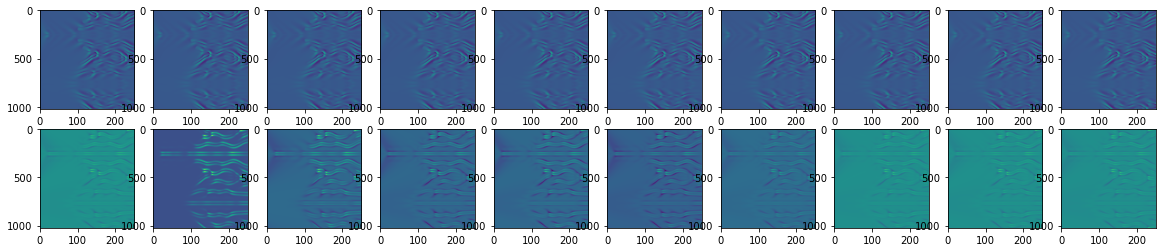

In [8]:
plt.figure(figsize=(20, 4))
num_plots = min(np.shape(optimizer.history_)[0], 10)
for j in range(num_plots):
    optimizer.coef_ = np.asarray(optimizer.history_)[-j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(u_flattened)  
    x_dot_test_predicted = np.reshape(x_dot_test_predicted, (len(x), len(t), 1))

    plt.subplot(2, num_plots, j + 1)
    plt.imshow(ut[:, :, 0], aspect='auto')
    plt.subplot(2, num_plots, num_plots + j + 1)
    plt.imshow(x_dot_test_predicted[:, :, 0], aspect='auto')
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(u_flattened, t=dt, metric=mean_squared_error))

# Test PDE functionality on Burgers' equation
Burgers' equation is
$u_t = -uu_x - u_{xx}$.

(256, 101) (101,) (256,)


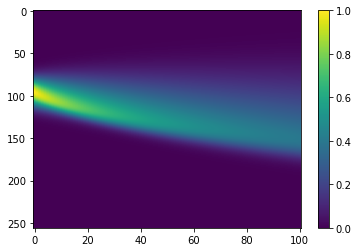

In [9]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.abs(data['usol'])   #+ np.random.randn(len(x), len(t)) / 20
dt = t[1] - t[0]
dx = x[1] - x[0]
print(np.shape(u), np.shape(t), np.shape(x))
plt.imshow(u, aspect='auto')
plt.colorbar()

In [10]:
# Need to compute u_t separately, and input into model.fit
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_temp = np.reshape(u[i, :], (len(u[i, :]), 1))
    ut[i, :] = ps.FiniteDifference()._differentiate(u_temp, t)
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]

u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1))
library_functions = [lambda x: x] #, lambda x: x * x]
library_function_names = [lambda x: x] #, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, derivative_order=3, spatial_grid=x)
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
print(pde_lib.get_feature_names())
model.print()

['x0', 'x0_1', 'x0_11', 'x0_111', 'x0x0_1', 'x0x0_11', 'x0x0_111']
x0' = 0.100 x0_11 + -1.001 x0x0_1


Model 0, MSE: 0.210210
Model 1, MSE: 0.210231
Model 2, MSE: 0.210230


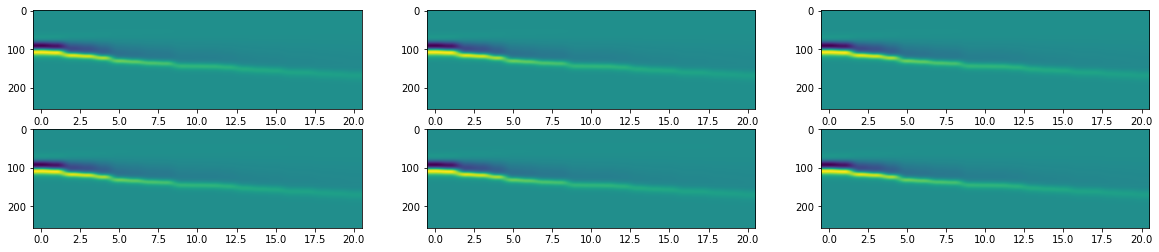

In [11]:
plt.figure(figsize=(20, 4))
for j in range(np.shape(optimizer.history_)[0]):
    optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(u_test_flattened)  
    x_dot_test_predicted = np.reshape(x_dot_test_predicted, (len(x), len(t_test), 1))

    plt.subplot(2, np.shape(optimizer.history_)[0], j + 1)
    plt.imshow(ut_test[:, :, 0], aspect='auto')
    plt.subplot(2, np.shape(optimizer.history_)[0], 
                   1 * np.shape(optimizer.history_)[0] + j + 1)
    plt.imshow(x_dot_test_predicted[:, :, 0], aspect='auto')
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(u_test_flattened, t=dt, metric=mean_squared_error))

# Test PDE functionality on Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. 

(128,) (128,)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


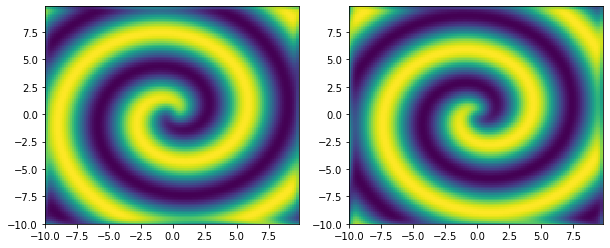

In [26]:
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2

def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Need to generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta=1.0
L = 20
n = 128
N = n * n;
x2 = np.linspace(- L / 2, L / 2, n + 1)
x = x2[:n]
y = x
n2 = int(n / 2)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
print(x.shape, kx.shape)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))

uvt = np.squeeze(np.hstack((np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))))
uvsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=uvt, t_eval=t, args=(K22, d1, d2, beta, n, N))
uvsol = uvsol.y

for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [27]:
# Need to compute u_t separately, and input into model.fit
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
ut = np.zeros((n, n, len(t), 2))
for i in range(n):
    for j in range(n):
        ut[i, j, :, :] = ps.FiniteDifference()._differentiate(u[i, j, :, :], t)
        
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
ut_train = ut[:, :, train, :]
ut_test = ut[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T
print(spatial_grid.shape, len(spatial_grid.shape))

u_train_flattened = np.reshape(u_train, (N * len(t_train), 2))
ut_train_flattened = np.reshape(ut_train, (N * len(t_train), 2))
u_test_flattened = np.reshape(u_test, (N * len(t_test), 2))
ut_test_flattened = np.reshape(ut_test, (N * len(t_test), 2))
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid)
optimizer = ps.SR3(threshold=0.5, thresholder='l1')
#optimizer = ps.SSR(max_iter=100)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
print(pde_lib.get_feature_names(), np.shape(pde_lib.get_feature_names()))
model.print()
#print(optimizer.coef_)
print(pde_lib.n_output_features_)

(128, 128, 2) 3
['x0', 'x1', 'x0x0x0', 'x1x1x1', 'x0x1x1', 'x0x0x1', 'x0_1', 'x1_1', 'x0_2', 'x1_2', 'x0_11', 'x1_11', 'x0_12', 'x1_12', 'x0_22', 'x1_22', 'x0x0_1', 'x0x1_1', 'x1x0_1', 'x1x1_1', 'x0x0x0x0_1', 'x0x0x0x1_1', 'x1x1x1x0_1', 'x1x1x1x1_1', 'x0x1x1x0_1', 'x0x1x1x1_1', 'x0x0x1x0_1', 'x0x0x1x1_1', 'x0x0_2', 'x0x1_2', 'x1x0_2', 'x1x1_2', 'x0x0x0x0_2', 'x0x0x0x1_2', 'x1x1x1x0_2', 'x1x1x1x1_2', 'x0x1x1x0_2', 'x0x1x1x1_2', 'x0x0x1x0_2', 'x0x0x1x1_2', 'x0x0_11', 'x0x1_11', 'x1x0_11', 'x1x1_11', 'x0x0x0x0_11', 'x0x0x0x1_11', 'x1x1x1x0_11', 'x1x1x1x1_11', 'x0x1x1x0_11', 'x0x1x1x1_11', 'x0x0x1x0_11', 'x0x0x1x1_11', 'x0x0_12', 'x0x1_12', 'x1x0_12', 'x1x1_12', 'x0x0x0x0_12', 'x0x0x0x1_12', 'x1x1x1x0_12', 'x1x1x1x1_12', 'x0x1x1x0_12', 'x0x1x1x1_12', 'x0x0x1x0_12', 'x0x0x1x1_12', 'x0x0_22', 'x0x1_22', 'x1x0_22', 'x1x1_22', 'x0x0x0x0_22', 'x0x0x0x1_22', 'x1x1x1x0_22', 'x1x1x1x1_22', 'x0x1x1x0_22', 'x0x1x1x1_22', 'x0x0x1x0_22', 'x0x0x1x1_22'] (76,)
x0' = 0.900 x1 + -1.095 x1_22 + -1.113 x0x0

# Check that PDE library is getting all the derivatives correct

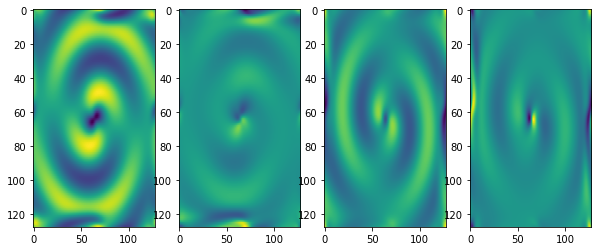

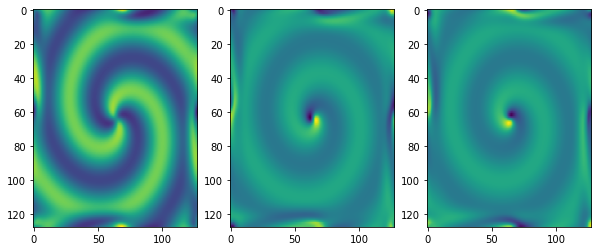

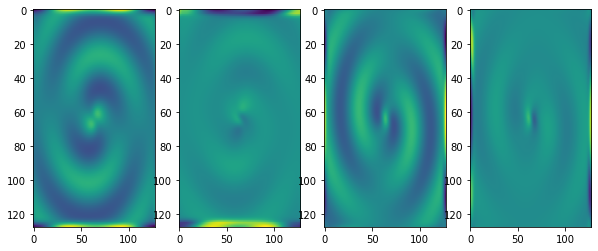

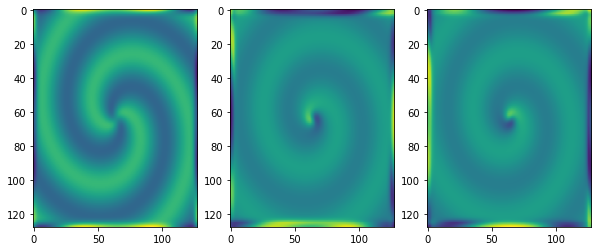

In [28]:
ux = pde_lib.u_derivs[:, :, :, :, 0]
uy = pde_lib.u_derivs[:, :, :, :, 1]
uxx = pde_lib.u_derivs[:, :, :, :, 2]
uyy = pde_lib.u_derivs[:, :, :, :, 4]

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(ux[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 2)
plt.imshow(uxx[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 3)
plt.imshow(uy[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 4)
plt.imshow(uyy[:, :, 10, 0], aspect='auto')

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(ux[:, :, 10, 0] + uy[:, :, 10, 1], aspect='auto')  # divergence
plt.subplot(1, 3, 2)
plt.imshow(uxx[:, :, 10, 0] + uyy[:, :, 10, 0], aspect='auto')  # laplacian(u)
plt.subplot(1, 3, 3)
plt.imshow(uxx[:, :, 10, 1] + uyy[:, :, 10, 1], aspect='auto')  # laplacian(v)

ux = np.zeros((n, n, len(t), 2))
uy = np.zeros((n, n, len(t), 2))
uxx = np.zeros((n, n, len(t), 2))
uyy = np.zeros((n, n, len(t), 2))
for i in range(len(t)):
    for j in range(n):
        ux[:, j, i, :] = ps.FiniteDifference(d=1)._differentiate(u[:, j, i, :], dx)
        uxx[:, j, i, :] = ps.FiniteDifference(d=2)._differentiate(u[:, j, i, :], dx)
    for j in range(n):
        uy[j, :, i, :] = ps.FiniteDifference(d=1)._differentiate(u[j, :, i, :], dy)
        uyy[j, :, i, :] = ps.FiniteDifference(d=2)._differentiate(u[j, :, i, :], dy)

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(ux[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 2)
plt.imshow(uxx[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 3)
plt.imshow(uy[:, :, 10, 0], aspect='auto')
plt.subplot(1, 4, 4)
plt.imshow(uyy[:, :, 10, 0], aspect='auto')

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(ux[:, :, 10, 0] + uy[:, :, 10, 1], aspect='auto')  # divergence
plt.subplot(1, 3, 2)
plt.imshow(uxx[:, :, 10, 0] + uyy[:, :, 10, 0], aspect='auto')  # laplacian(u)
plt.subplot(1, 3, 3)
plt.imshow(uxx[:, :, 10, 1] + uyy[:, :, 10, 1], aspect='auto')  # laplacian(v)

Model 0, MSE: 8.443267
Model 1, MSE: 10.693330
Model 2, MSE: 10.693006
Model 3, MSE: 10.693006
Model 4, MSE: 10.693006


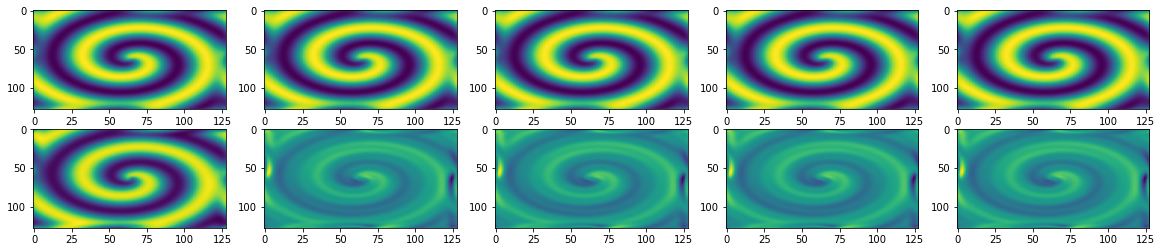

In [29]:
plt.figure(figsize=(20, 4))
n_plots = min(np.shape(optimizer.history_)[0], 10)
for j in range(n_plots):
    optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(u_test_flattened)  
    x_dot_test_predicted = np.reshape(x_dot_test_predicted, (n, n, len(t_test), 2))

    plt.subplot(2, n_plots, j + 1)
    plt.imshow(ut_test[:, :, 10, 0], aspect='auto')
    plt.subplot(2, n_plots, n_plots + j + 1)
    plt.imshow(x_dot_test_predicted[:, :, 10, 0], aspect='auto')
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(u_test_flattened, t=dt, metric=mean_squared_error))